In [1]:
%run notebook_utils.py

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib

# set big font in plots
SMALL_SIZE = 20
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)

In [3]:
%cd ..
from langid import WrappedVectorizer, np_sanitize, sanitize
%cd -

/Users/Lin/git/SwigSpot/language-detection
/Users/Lin/git/SwigSpot/language-detection/notebooks


In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.optimizers import SGD
import numpy
# fix random seed for reproducibility
numpy.random.seed(7)

Using TensorFlow backend.


# Features

In [5]:
X_train, X_test, y_train, y_test = load_split_data()
sms_any_X, sms_any_y = load_sms_any()
X_valid, y_valid = load_validation_data()

# Neural Net -- First attempt

In this first attempt, we use features from Swiss German only and limit the feature vector to 1000 trigrams. 

The model has only one hidden layerThe number of iterations is 50.

In [6]:
ngram_range = (3,3)
num_features = 1000

# create the vectorizer
vectorizer = WrappedVectorizer(analyzer='char', ngram_range=ngram_range, sg_only=True, sanitizer=np_sanitize,
                             max_features=num_features, sublinear_tf=True, use_idf=True, norm='l2')

# create the features for training
X = vectorizer.fit_transform(X_train, y_train)

In [7]:
# create model
hidden_size = 500
output_size = len(langs)

model = Sequential()
# using sigmoid vs relu, get got:
#   loss=1.5869, accuracy: 59.4286% and 10660 errors on SMS... => relu is better
model.add(Dense(hidden_size, input_dim=num_features, activation='relu')) # hidden layer: same #neurons as input layer
model.add(Dense(output_size, activation='sigmoid')) # output layer: one for each language
model.add(Activation("softmax")) # add probabilities to the class output

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2505      
_________________________________________________________________
activation_1 (Activation)    (None, 5)                 0         
Total params: 503,005
Trainable params: 503,005
Non-trainable params: 0
_________________________________________________________________


In [8]:
# train the model using SGD
print("[INFO] compiling model...")
sgd = SGD(lr=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])
model.fit(X, y_train, epochs=50, batch_size=128, verbose=1)

[INFO] compiling model...
Epoch 1/50
29551/29551 [==============================] - 1s 36us/step - loss: 1.6086 - acc: 0.2580
Epoch 2/50
29551/29551 [==============================] - 1s 33us/step - loss: 1.6064 - acc: 0.3502
Epoch 3/50
29551/29551 [==============================] - 1s 33us/step - loss: 1.6041 - acc: 0.4380
Epoch 4/50
29551/29551 [==============================] - 1s 32us/step - loss: 1.6018 - acc: 0.5261
Epoch 5/50
29551/29551 [==============================] - 1s 31us/step - loss: 1.5994 - acc: 0.6002
Epoch 6/50
29551/29551 [==============================] - 1s 32us/step - loss: 1.5969 - acc: 0.6661
Epoch 7/50
29551/29551 [==============================] - 1s 32us/step - loss: 1.5943 - acc: 0.7152
Epoch 8/50
29551/29551 [==============================] - 1s 33us/step - loss: 1.5915 - acc: 0.7480
Epoch 9/50
29551/29551 [==============================] - 1s 32us/step - loss: 1.5886 - acc: 0.7739
Epoch 10/50
29551/29551 [==============================] - 1s 35us/step - 

[INFO] evaluating on testing set...
7388/7388 [==============================] - 0s 20us/step
[INFO] loss=1.2734, accuracy: 96.3048%


Testing recall on SMS:

total samples    10692
total errors       373 (3.49%)
---------------------------------
languages detected
    de      319
    fr        9
    en       20
    it       25
    sg    10319


Validate using the leipzig validation set:

             precision    recall  f1-score   support

         de     0.9076    0.9583    0.9322      2613
         fr     0.9830    0.9744    0.9787      2613
         en     0.9842    0.9533    0.9685      2613
         it     0.9896    0.9816    0.9856      2613
         sg     0.9078    0.9009    0.9043      2613

avg / total     0.9544    0.9537    0.9539     13065



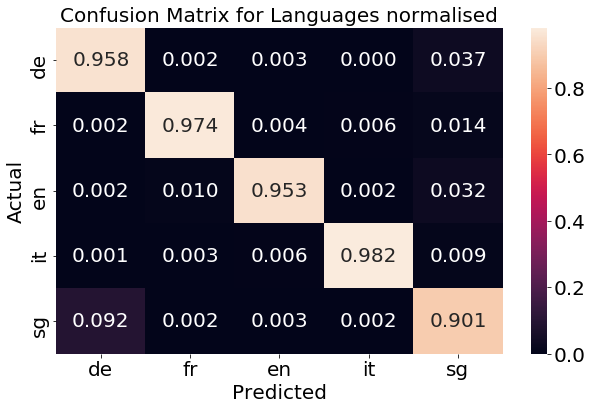

In [9]:
# show the accuracy on the testing set
print("[INFO] evaluating on testing set...")
(loss, accuracy) = model.evaluate(vectorizer.transform(X_test), y_test, batch_size=128, verbose=1)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss, accuracy * 100))

print("\n\nTesting recall on SMS:\n")
sms_predicted = model.predict(vectorizer.transform(sms_sg)).argmax(axis=1)
eval_recall_sms(sms_predicted)

print("\n\nValidate using the leipzig validation set:\n")
valid_predicted = model.predict(vectorizer.transform(X_valid)).argmax(axis=1)
print_results(y_valid, valid_predicted)
plot_confusion_matrix(y_valid, valid_predicted, normalised=True)

# Another attempt

In [10]:
ngram_range2 = (3,3)
num_features2 = 6000

# create the vectorizer
vectorizer2 = WrappedVectorizer(analyzer='char', ngram_range=ngram_range2, sg_only=False, sanitizer=np_sanitize,
                             max_features=num_features2, sublinear_tf=True, use_idf=True, norm='l2')

# create the features for training
X2 = vectorizer2.fit_transform(X_train, y_train)

In [14]:
# create model

hidden_size2_1 = 2000
hidden_size2_2 = 500
output_size2 = len(langs)

model2 = Sequential()
# using sigmoid vs relu, get got:
#   loss=1.5869, accuracy: 59.4286% and 10660 errors on SMS... => relu is better
model2.add(Dense(hidden_size2_1, input_dim=num_features2, activation='relu')) 
model2.add(Dense(hidden_size2_2, input_dim=hidden_size2_1, activation='relu')) 
model2.add(Dense(output_size2, activation='sigmoid')) 
model2.add(Activation("softmax")) # add probabilities to the class output

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 2000)              12002000  
_________________________________________________________________
dense_7 (Dense)              (None, 500)               1000500   
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 2505      
_________________________________________________________________
activation_3 (Activation)    (None, 5)                 0         
Total params: 13,005,005
Trainable params: 13,005,005
Non-trainable params: 0
_________________________________________________________________


In [15]:
# train the model using SGD
print("[INFO] compiling model...")
model2.compile(loss="sparse_categorical_crossentropy", optimizer=SGD(lr=0.01), metrics=["accuracy"])
model2.fit(X2, y_train, epochs=10, batch_size=128, verbose=1)

[INFO] compiling model...
Epoch 1/10
29551/29551 [==============================] - 24s 809us/step - loss: 1.6092 - acc: 0.2180
Epoch 2/10
29551/29551 [==============================] - 25s 852us/step - loss: 1.6084 - acc: 0.2667
Epoch 3/10
29551/29551 [==============================] - 25s 859us/step - loss: 1.6076 - acc: 0.3209
Epoch 4/10
29551/29551 [==============================] - 25s 850us/step - loss: 1.6068 - acc: 0.3813
Epoch 5/10
29551/29551 [==============================] - 27s 926us/step - loss: 1.6059 - acc: 0.4260
Epoch 6/10
29551/29551 [==============================] - 29s 990us/step - loss: 1.6049 - acc: 0.4857
Epoch 7/10
29551/29551 [==============================] - 29s 991us/step - loss: 1.6038 - acc: 0.5312
Epoch 8/10
29551/29551 [==============================] - 28s 957us/step - loss: 1.6026 - acc: 0.5790
Epoch 9/10
29551/29551 [==============================] - 30s 1ms/step - loss: 1.6013 - acc: 0.6447
Epoch 10/10
29551/29551 [==============================] -

[INFO] evaluating on testing set...
7388/7388 [==============================] - 2s 271us/step
[INFO] loss=1.5994, accuracy: 72.8208%


Testing recall on SMS:

total samples    10692
total errors       148 (1.38%)
---------------------------------
languages detected
    de      124
    fr        1
    en       23
    it    10544


Validate using the leipzig validation set:

             precision    recall  f1-score   support

         de     0.9002    0.6177    0.7326      2613
         fr     0.9795    0.6406    0.7746      2613
         en     1.0000    0.4945    0.6617      2613
         it     0.9374    0.9399    0.9387      2613
         sg     0.4461    0.9648    0.6101      2613

avg / total     0.8526    0.7315    0.7436     13065



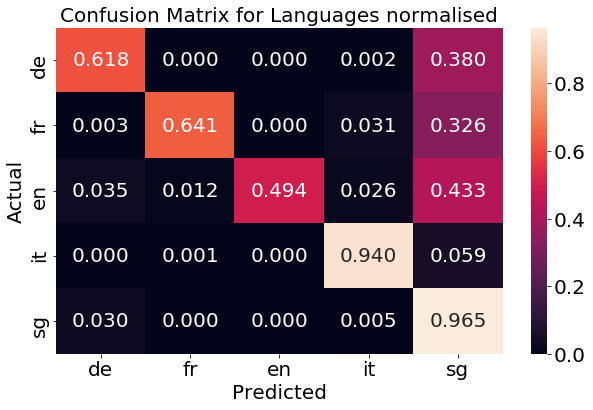

In [16]:
# show the accuracy on the testing set
print("[INFO] evaluating on testing set...")
(loss, accuracy) = model2.evaluate(vectorizer2.transform(X_test), y_test, batch_size=128, verbose=1)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss, accuracy * 100))

print("\n\nTesting recall on SMS:\n")
sms_predicted = model2.predict(vectorizer2.transform(sms_sg)).argmax(axis=1)
eval_recall_sms(sms_predicted)

print("\n\nValidate using the leipzig validation set:\n")
valid_predicted = model2.predict(vectorizer2.transform(X_valid)).argmax(axis=1)
print_results(y_valid, valid_predicted)
plot_confusion_matrix(y_valid, valid_predicted, normalised=True)

# Yet another attempt

In [70]:
ngram_range3 = (3,3)
num_features3 = 3000

# create the vectorizer
vectorizer3 = WrappedVectorizer(analyzer='char', ngram_range=ngram_range3, sg_only=False,
                             max_features=num_features3, sublinear_tf=True, use_idf=True, norm='l2')

# create the features for training
X3 = vectorizer3.fit_transform(X_train, y_train)

In [86]:
# create model

hidden_size3_1 = 3000
#hidden_size3_2 = 50
output_size3 = len(langs)

model3 = Sequential()
# using sigmoid vs relu, get got:
#   loss=1.5869, accuracy: 59.4286% and 10660 errors on SMS... => relu is better
model3.add(Dense(hidden_size3_1, input_dim=num_features3, activation='relu')) 
#model3.add(Dense(hidden_size3_2, input_dim=hidden_size3_1, activation='relu')) 
model3.add(Dense(output_size3, activation='sigmoid')) 
model3.add(Activation("softmax")) # add probabilities to the class output

model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 3000)              9003000   
_________________________________________________________________
dense_33 (Dense)             (None, 5)                 15005     
_________________________________________________________________
activation_13 (Activation)   (None, 5)                 0         
Total params: 9,018,005
Trainable params: 9,018,005
Non-trainable params: 0
_________________________________________________________________


In [87]:
# train the model using SGD
print("[INFO] compiling model...")
model3.compile(loss="sparse_categorical_crossentropy", optimizer=SGD(lr=0.01), metrics=["accuracy"])
model3.fit(X3, y_train, epochs=50, batch_size=128, verbose=1)

[INFO] compiling model...
Epoch 1/50
29551/29551 [==============================] - 17s 569us/step - loss: 1.6092 - acc: 0.2224
Epoch 2/50
29551/29551 [==============================] - 16s 552us/step - loss: 1.6078 - acc: 0.3283
Epoch 3/50
29551/29551 [==============================] - 17s 591us/step - loss: 1.6064 - acc: 0.4319
Epoch 4/50
29551/29551 [==============================] - 17s 574us/step - loss: 1.6050 - acc: 0.5536
Epoch 5/50
29551/29551 [==============================] - 19s 640us/step - loss: 1.6035 - acc: 0.6480
Epoch 6/50
29551/29551 [==============================] - 20s 670us/step - loss: 1.6021 - acc: 0.7181
Epoch 7/50
29551/29551 [==============================] - 19s 640us/step - loss: 1.6006 - acc: 0.7666
Epoch 8/50
29551/29551 [==============================] - 21s 719us/step - loss: 1.5990 - acc: 0.8027
Epoch 9/50
29551/29551 [==============================] - 20s 690us/step - loss: 1.5974 - acc: 0.8339
Epoch 10/50
29551/29551 [==============================]

[INFO] evaluating on testing set...
7388/7388 [==============================] - 1s 153us/step
[INFO] loss=1.4048, accuracy: 97.8343%


Testing recall on SMS:

total samples    10706
total errors       405 (3.78%)
---------------------------------
languages detected
    de      372
    fr        9
    en       10
    it       14
    sg    10301


Validate using the leipzig validation set:

             precision    recall  f1-score   support

         de     0.8927    0.9835    0.9359      2613
         fr     0.9977    0.9962    0.9969      2613
         en     0.9962    0.9920    0.9941      2613
         it     0.9969    0.9989    0.9979      2613
         sg     0.9750    0.8794    0.9247      2613

avg / total     0.9717    0.9700    0.9699     13065



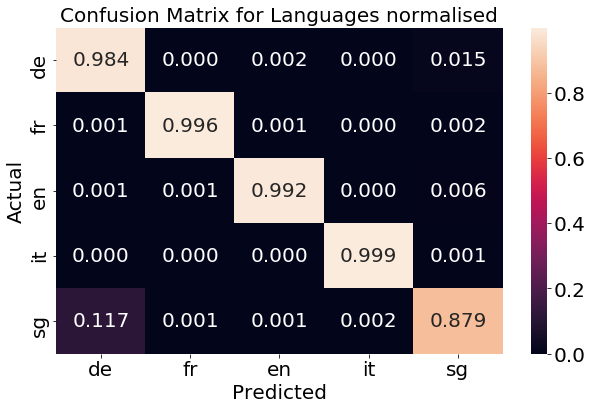

In [88]:
# show the accuracy on the testing set
print("[INFO] evaluating on testing set...")
(loss, accuracy) = model3.evaluate(vectorizer3.transform(X_test), y_test, batch_size=128, verbose=1)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss, accuracy * 100))

print("\n\nTesting recall on SMS:\n")
sms_predicted = model3.predict(vectorizer3.transform(sms_sg)).argmax(axis=1)
eval_recall_sms(sms_predicted)

print("\n\nValidate using the leipzig validation set:\n")
valid_predicted = model3.predict(vectorizer3.transform(X_valid)).argmax(axis=1)
print_results(y_valid, valid_predicted)
plot_confusion_matrix(y_valid, valid_predicted, normalised=True)

array([4, 3, 4, ..., 4, 4, 4])